# Guide to Using Cohere's Embed V3 Multimodal Model on Amazon Sagemaker

Cohere's embeddings model, Embed 3 is an industry-leading AI search model that is designed to transform semantic search and generative AI applications. Cohere Embed 3 is now multimodal and it is capable of generating embeddings from both text and images. This enables enterprises to unlock real value from their vast amounts of data that exist in image form. Businesses can now build systems that accurately search important multimodal assets such as complex reports, ecommerce product catalogs, and design files to boost workforce productivity. This upgrade makes Embed 3 the most generally capable multimodal embedding model on the market. 

## Getting Started

This sample notebook will be using Cohere Embed v3 family of models using Amazon SageMaker:
[Cohere Embed Model v3 - English](https://aws.amazon.com/marketplace/pp/prodview-qd64mji3pbnvk)


> **Note**: This is a reference notebook and it cannot run unless you make changes suggested in the notebook.

### Pre-requisites:
1. **Note**: This notebook contains elements which render correctly in Jupyter interface. Open this notebook from an Amazon SageMaker Notebook Instance or Amazon SageMaker Studio.
1. Use kernel either *conda_python3*, *conda_pytorch_p310* or *conda_tensorflow2_p310*.
1. Ensure that IAM role used has **AmazonSageMakerFullAccess**
1. To deploy this ML model successfully, ensure that:
    1. Either your IAM role has these three permissions and you have authority to make AWS Marketplace subscriptions in the AWS account used: 
        1. **aws-marketplace:ViewSubscriptions**
        1. **aws-marketplace:Unsubscribe**
        1. **aws-marketplace:Subscribe**  
    2. or your AWS account has a subscription to one of the models listed above. If so, skip step: [Subscribe to the model package](#1.-Subscribe-to-the-model-package)


#### Usage instructions
You can run this notebook one cell at a time (By using Shift+Enter for running a cell).

### Step 1: Imports and Install Dependencies

In [1]:
!pip install striprtf hnswlib --quiet
!pip install boto3 --quiet
!pip install cohere-aws==0.8.16 --quiet

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
autogluon-multimodal 1.1.1 requires nvidia-ml-py3==7.352.0, which is not installed.
aiobotocore 2.13.2 requires botocore<1.34.132,>=1.34.70, but you have botocore 1.35.54 which is incompatible.
amazon-sagemaker-sql-magic 0.1.3 requires sqlparse==0.5.0, but you have sqlparse 0.5.1 which is incompatible.
autogluon-core 1.1.1 requires scikit-learn<1.4.1,>=1.3.0, but you have scikit-learn 1.4.2 which is incompatible.
autogluon-features 1.1.1 requires scikit-learn<1.4.1,>=1.3.0, but you have scikit-learn 1.4.2 which is incompatible.
autogluon-multimodal 1.1.1 requires omegaconf<2.3.0,>=2.1.1, but you have omegaconf 2.3.0 which is incompatible.
autogluon-multimodal 1.1.1 requires scikit-learn<1.4.1,>=1.3.0, but you have scikit-learn 1.4.2 which is incompatible.
autogluon-tabular 1.1.1 requires scikit-learn<1.4.1,>=1.3.0

In [1]:
import boto3
from cohere_aws import Client
from striprtf.striprtf import rtf_to_text
from PIL import Image
import base64
import hnswlib
from io import BytesIO
import json
import numpy as np
from PIL import Image
import os

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml


### Step 2: Create an endpoint and perform real-time inference

One you subscribe to the model on AWS Marketplace, a model ARN will be available for you to use and copy as seen below.

In [2]:
# Set model_package variables for endpoint creation
#model_package = "arn:aws:sagemaker:us-east-1:865070037744:model-package/cohere-embed-english-v3-7-6d097a095fdd314d90a8400a620cac54"
model_package = "arn:aws:sagemaker:us-east-1:865070037744:model-package/cohere-embed-english-v3-7-6d097a095fdd314d90a8400a620cac54"

In [3]:
# List existing IAM roles to identify the existing sagemamker execution role
iam = boto3.client('iam')
roles = iam.list_roles(
    PathPrefix='/service-role/',
    MaxItems=100
)
for role in roles['Roles']:
    if 'sagemaker.amazonaws.com' in role['AssumeRolePolicyDocument']['Statement'][0]['Principal']['Service']:
        execution_role_arn = role['Arn']
        break

In [4]:
# Create a real-time inference endpoint
sagemaker = boto3.client('sagemaker')
sagemaker_runtime = boto3.client('sagemaker-runtime')

---
**Start of section to only run cells once if endpoint does not exist yet**

Below is showing how to create a model, endpoint configuration and then the sagemaker endpoint after you have subscribed to the embed V3 model in AWS Marketplace. If you already have your endpoint or it was created on the AWS console, then just replace with the endpoint name you have used after the next 3 cells

In [ ]:
# Create model
sagemaker.create_model(ModelName='Model-Cohere-Embed-Model-v3-English-1',
    ExecutionRoleArn=execution_role_arn,
    PrimaryContainer={
        'ModelPackageName': model_package
    },
    EnableNetworkIsolation=True)

In [ ]:
# Create endpoint config and endpoint
sagemaker.create_endpoint_config(EndpointConfigName='EndpointConfig-Cohere-Embed-Model-v3-English-1',
    ProductionVariants=[
        {
            'VariantName': 'variant-1',
            'ModelName': 'Model-Cohere-Embed-Model-v3-English-1',
            'InstanceType': 'ml.g5.xlarge',
            'InitialInstanceCount': 1
        }
    ])

In [10]:
# Create endpoint
sagemaker.create_endpoint(
    EndpointName='Endpoint-Cohere-Embed-Model-v3-English-1',
    EndpointConfigName='EndpointConfig-Cohere-Embed-Model-v3-English-1'
)

{'EndpointArn': 'arn:aws:sagemaker:us-east-1:890742598932:endpoint/Endpoint-Cohere-Embed-Model-v3-English-1',
 'ResponseMetadata': {'RequestId': 'e7240622-a811-43ac-8abf-8b817cf715bd',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': 'e7240622-a811-43ac-8abf-8b817cf715bd',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '108',
   'date': 'Wed, 23 Oct 2024 20:44:16 GMT'},
  'RetryAttempts': 0}}

---
**End of section to only run cells once**

Next, we want to ensure that our endpoint status is "InService"

In [7]:
# Check endpoint status, keep running the cell for new updates!
def check_endpoint_status(endpoint_name):
    try:
        response = sagemaker.describe_endpoint(EndpointName=endpoint_name)
        return response['EndpointStatus']
    except Exception as e:
        print(f"Error checking endpoint status: {e}")
        return None

# Example usage
endpoint_name = 'Endpoint-Cohere-Embed-Model-v3-English-1'
status = check_endpoint_status(endpoint_name)
if status:
    print(f"Endpoint status: {status}")
else:
    print("Error getting endpoint status.")

Endpoint status: InService


In [8]:
endpoint_name = 'Endpoint-Cohere-Embed-Model-v3-English-1'

<h2>Inference Example</h2>

The following code example illustrates how to perform real-time inference using Cohere embed 3

In [9]:
import requests
import base64
import os
import mimetypes
import numpy as np
from IPython.display import Image, display
import tqdm
import tqdm.auto


<b>Helper functions:</b>

Helper functions that determine whether input document is text or image, and download images given a list of URLs.


In [10]:
def is_image(doc):
    return (doc.endswith(".jpg") or doc.endswith(".png")) and os.path.exists(doc)

def is_txt(doc):
    return (doc.endswith(".txt")) and os.path.exists(doc)

def download_images(image_urls):
    image_names = []

    #print("Download some example images we want to embed")
    for url in image_urls:
        image_name = os.path.basename(url)
        image_names.append(image_name)

        if not os.path.exists(image_name):
            with open(image_name, "wb") as fOut:
                fOut.write(requests.get(url, stream=True).content)

        #print(image_name)
        #display(Image(filename=image_name, height=300))
    return image_names

<b>Generate embedding for text/image inputs:</b>

Here is a compute_embeddings() function we defined that will accept multi-modal inputs to generate embeddings with Cohere embed 3.


In [11]:
def compute_embeddings(docs):
    # Compute the embeddings
    embeddings = []
    for doc in tqdm.auto.tqdm(docs, desc="encoding"):
        if is_image(doc):
            print("Encode image:", doc)
            # Doc is an image, encode it as an image

            # Convert the images to base64
            with open(doc, "rb") as fIn:
                img_base64 = base64.b64encode(fIn.read()).decode("utf-8")
            
            #Get the mime type for the image
            mime_type = mimetypes.guess_type(doc)[0]
            
            # response = co.embed(
            #         images=[f"data:{mime_type};base64,{img_base64}"],
            #         model=embed_model,
            #         input_type="image",
            #     )
            #print("mime_type",mime_type)
            
            payload = {
                "model": "embed-english-v3.0",
                "input_type": 'image',
                "embedding_types": ["float"],
                "images": [f"data:{mime_type};base64,{img_base64}"]
            }
        
            response = sagemaker_runtime.invoke_endpoint(
                EndpointName=endpoint_name,
                ContentType='application/json',
                Body=json.dumps(payload)
            )

            response = json.loads(response['Body'].read().decode("utf-8"))
            response = response["embeddings"]["float"][0]
        elif is_txt(doc):
            # Doc is a text file, encode it as a document
            with open(doc, "r") as fIn:
                text = fIn.read()

            print("Encode img desc:", doc, " - Content:", text[0:100]+"...")
            #Encode as document
            # response = co.embed(
            #         texts=[text],
            #         model="embed-english-v3.0",
            #         input_type="search_document",
            #     )
            
            payload = {
                "texts": [text],
                "model": "embed-english-v3.0",
                "input_type": "search_document",
            }
            
            response = sagemaker_runtime.invoke_endpoint(
                EndpointName=endpoint_name,
                ContentType='application/json',
                Body=json.dumps(payload)
            )
            response = json.loads(response['Body'].read().decode("utf-8"))
            response = response["embeddings"][0]
        else:
            #Encode as document
            # response = co.embed(
            #         texts=[doc],
            #         model=embed_model,
            #         input_type="search_document",
            #     )
            
            payload = {
                "texts": [doc],
                "model": "embed-english-v3.0",
                "input_type": "search_document",
            }
            
            response = sagemaker_runtime.invoke_endpoint(
                EndpointName=endpoint_name,
                ContentType='application/json',
                Body=json.dumps(payload)
            )
            response = json.loads(response['Body'].read().decode("utf-8"))
            response = response["embeddings"][0]
        embeddings.append(response)
    return np.asarray(embeddings, dtype="object")



<b>Finding the most relevant embedding based on query:</b>

Search() function generates query embedding and compute a similarity matrix between the query and embeddings


In [12]:
def search(query, embeddings, docs):
    # Get the query embedding
    
    payload = {
        "texts": [query],
        "model": "embed-english-v3.0",
        "input_type": "search_document",
    }
    
    response = sagemaker_runtime.invoke_endpoint(
        EndpointName=endpoint_name,
        ContentType='application/json',
        Body=json.dumps(payload)
    )
    query_emb = json.loads(response['Body'].read().decode("utf-8"))
    query_emb = query_emb["embeddings"][0]

    # Compute L2 norms of the vector and matrix rows
    vector_norm = np.linalg.norm(query_emb)
    matrix_norms = np.linalg.norm(embeddings)

    # Compute the dot product between the vector and each row of the matrix
    dot_products = np.dot(embeddings, query_emb)
    
    
    # Compute cosine similarities
    similarity = dot_products / (matrix_norms * vector_norm)

    # Sort decreasing most to least similar
    top_hits = np.argsort(-similarity)

    print("Query:", query, "\n")
    print(similarity)
    print("Search results:")
    for rank, idx in enumerate(top_hits):
        print(f"#{rank+1}: ({similarity[idx]*100:.2f})")
        if is_image(docs[idx]):
            print(docs[idx])
            display(Image(filename=docs[idx], height=300))
        elif is_txt(docs[idx]):
            print(docs[idx]+" - Image description:")
            with open(docs[idx], "r") as fIn:
                print(fIn.read())
            #display(Image(filename=docs[idx].replace(".txt", ".jpg"), height=300))
        else:
            print(docs[idx])
        print("--------")


<b>Now let’s see how this work in action!</b>

Let’s first assemble all the input documents, notice that there are both text and image inputs.


In [13]:
# Download images
image_urls = [
    "https://images-na.ssl-images-amazon.com/images/I/418sAk6aPML.jpg",
    "https://images-na.ssl-images-amazon.com/images/I/41uBn5pYI1L.jpg",
    "https://images-na.ssl-images-amazon.com/images/I/41L2RXSdJeL.jpg",
    "https://images-na.ssl-images-amazon.com/images/I/41SKvfCWneL.jpg",
    "https://images-na.ssl-images-amazon.com/images/I/41E1muwarUL.jpg",
    "https://images-na.ssl-images-amazon.com/images/I/41%2BISwvovXL.jpg",
    "https://images-na.ssl-images-amazon.com/images/I/419gcLIN3dL.jpg"
]
image_names = download_images(image_urls)
text_docs = [
    "Peppa sounds and a Peppa tune at the touch of a button.",
    "2 scooters in 1 – flip the base to create a ride on or scooter.",
    "Secure, integrated deck – scooter folds away and locks in place.",
    "FOOT-TO-FLOOR RIDE ON: Featuring a cute bug face in purple and white, four legs, and handlebar antennas, the ScrambleBug delivers 360 degrees of fun, friendly, and delightful playtime.",
    "McLaren P1 has seat belt option and it starts with realistic engine start sound, great for kids ages 2-10."
]

docs = image_names + text_docs
print("Total docs:", len(docs))
print(docs)



Total docs: 12
['418sAk6aPML.jpg', '41uBn5pYI1L.jpg', '41L2RXSdJeL.jpg', '41SKvfCWneL.jpg', '41E1muwarUL.jpg', '41%2BISwvovXL.jpg', '419gcLIN3dL.jpg', 'Peppa sounds and a Peppa tune at the touch of a button.', '2 scooters in 1 – flip the base to create a ride on or scooter.', 'Secure, integrated deck – scooter folds away and locks in place.', 'FOOT-TO-FLOOR RIDE ON: Featuring a cute bug face in purple and white, four legs, and handlebar antennas, the ScrambleBug delivers 360 degrees of fun, friendly, and delightful playtime.', 'McLaren P1 has seat belt option and it starts with realistic engine start sound, great for kids ages 2-10.']


In [14]:
embeddings = compute_embeddings(docs)
print("Doc embeddings shape:", embeddings.shape)

encoding:   0%|          | 0/12 [00:00<?, ?it/s]

Encode image: 418sAk6aPML.jpg
Encode image: 41uBn5pYI1L.jpg
Encode image: 41L2RXSdJeL.jpg
Encode image: 41SKvfCWneL.jpg
Encode image: 41E1muwarUL.jpg
Encode image: 41%2BISwvovXL.jpg
Encode image: 419gcLIN3dL.jpg
Doc embeddings shape: (12, 1024)


In [15]:
embeddings.shape

(12, 1024)

Query: McLaren car for kids 

[0.15239751140029462 0.10863024716172621 0.10051367028066618
 0.12358346755841298 0.11783567771323539 0.12720485151681113
 0.1015507752172397 0.12480795272288697 0.08230669779584017
 0.09011679940184265 0.07176040137380932 0.16041663169147222]
Search results:
#1: (16.04)
McLaren P1 has seat belt option and it starts with realistic engine start sound, great for kids ages 2-10.
--------
#2: (15.24)
418sAk6aPML.jpg


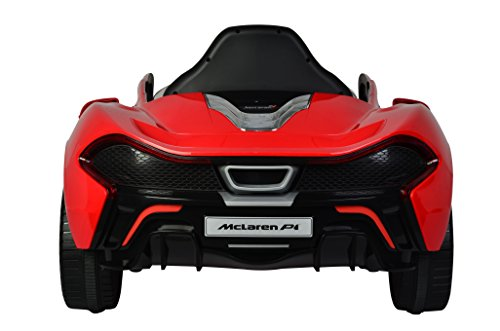

--------
#3: (12.72)
41%2BISwvovXL.jpg


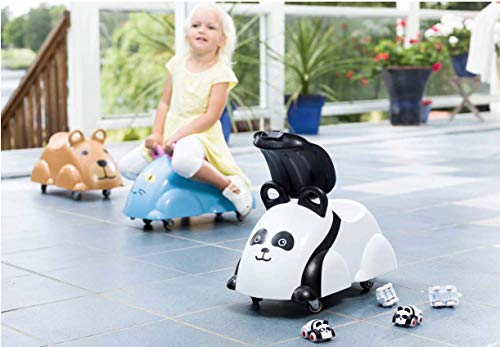

--------
#4: (12.48)
Peppa sounds and a Peppa tune at the touch of a button.
--------
#5: (12.36)
41SKvfCWneL.jpg


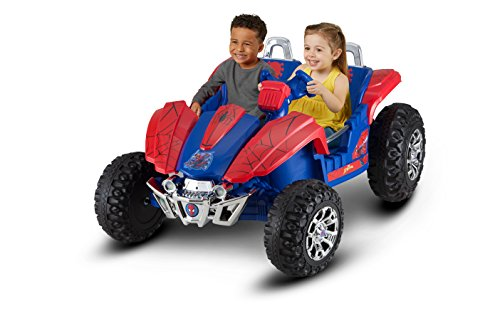

--------
#6: (11.78)
41E1muwarUL.jpg


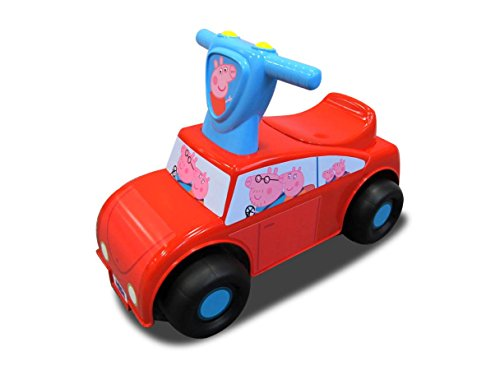

--------
#7: (10.86)
41uBn5pYI1L.jpg


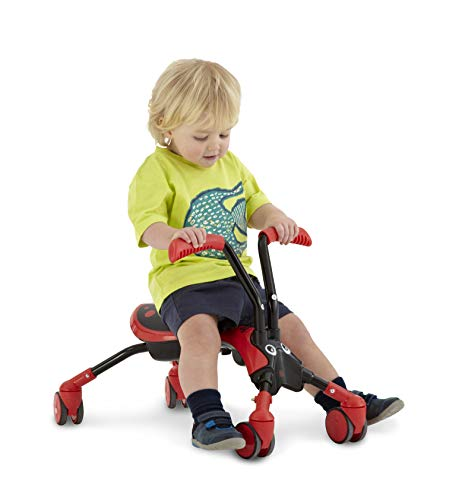

--------
#8: (10.16)
419gcLIN3dL.jpg


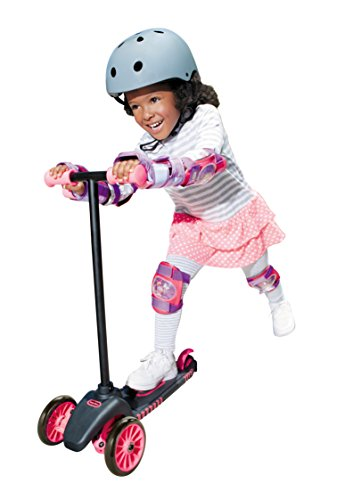

--------
#9: (10.05)
41L2RXSdJeL.jpg


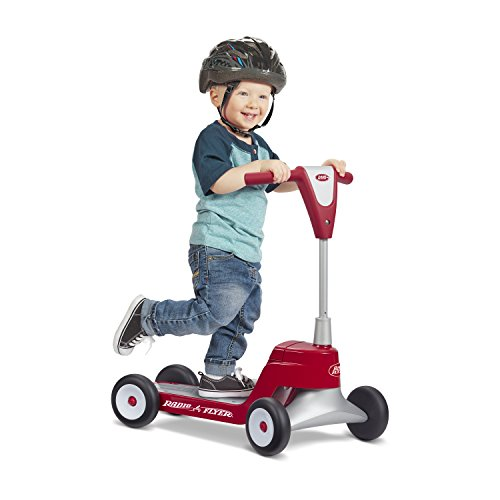

--------
#10: (9.01)
Secure, integrated deck – scooter folds away and locks in place.
--------
#11: (8.23)
2 scooters in 1 – flip the base to create a ride on or scooter.
--------
#12: (7.18)
FOOT-TO-FLOOR RIDE ON: Featuring a cute bug face in purple and white, four legs, and handlebar antennas, the ScrambleBug delivers 360 degrees of fun, friendly, and delightful playtime.
--------


In [16]:
search("McLaren car for kids", embeddings, docs)

### Step 4: Clean Up

If the endpoint was created by the execution of this notebook, then make sure to delete the endpoint after completion to avoid charges. Skip the below step if you are connecting to an rerank existing endpoint

In [37]:
# Delete the endpoint
# Skip this step if created through the AWS console

sagemaker.delete_endpoint(EndpointName='Endpoint-Cohere-Embed-Model-v3-English-1')
sagemaker.close()

**Note, if you need to create the same endpoint again, run the create_endpoint() function in the cell previously generated only. No need to run create_model() and create_endpoint_config()

## Conclusion

In this notebook we walked through how to leverage Cohere's Embed V3 multimodal model, capable of generating embeddings from both text and images. This enables enterprises to unlock value from their vast image data, allowing them to build powerful search and recommendation systems across multimodal assets like product catalogs, design files, and business reports. 

Cohere Embed 3 is now available on Amazon SageMaker, allowing customers to seamlessly deploy this state-of-the-art multimodal embeddings model and leverage it in their own applications. Key use cases include enhanced e-commerce search, efficient data-driven decision making with visual insights, and streamlined creative workflows. Cohere's multimodal embeddings can further improve semantic search when combined with Cohere's Rerank models, providing more contextual relevance to generative AI systems.